In [34]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [35]:
img_path = "/shed/photo/export/watkins_glen_camping_aug2020/instagram/0003_DSC07470.png"

In [36]:
img = cv2.imread(img_path)
scale = 0.1
h, w, _ = img.shape
new_h = int(h * scale)
new_w = int(w * scale)
img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [40]:
img.reshape(-1, 3).max(axis=0)

array([179, 255, 225], dtype=uint8)

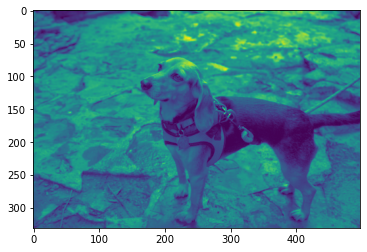

In [26]:
plt.imshow(img[:, :, 2])

In [28]:
h, w, _ = img.shape

In [47]:
y = np.linspace(0, 1, h)
x = np.linspace(0, 1, w)
xx, yy = np.meshgrid(x, y)
X = np.stack([xx, yy], axis=-1)

In [48]:
X.shape

(331, 497, 2)

In [49]:
xx.shape

(331, 497)

In [50]:
y.shape

(331,)

In [51]:
x.shape

(497,)

In [52]:
img.shape

(331, 497, 3)

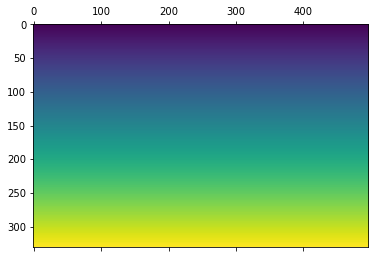

In [53]:
plt.matshow(X[:, :, 1])

In [41]:
b = np.eye(2)
a = np.ones(b.shape[0])

In [75]:
q = np.concatenate([a * np.sin((2.*np.pi*X) @ b.T), a * np.cos((2.*np.pi*X) @ b.T)], axis=-1)
q.shape

(331, 497, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


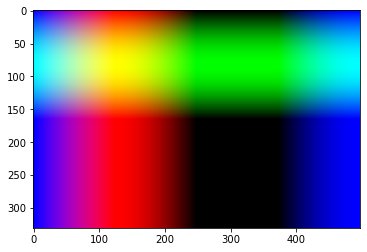

In [74]:
plt.imshow(q[:, :, :-1])

In [76]:
X.shape

(331, 497, 2)

In [78]:
X = X.reshape(h * w, -1)

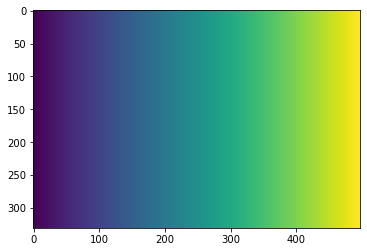

In [85]:
plt.imshow(X.reshape(h, w, -1)[:, :, 0])

In [86]:
import torch

In [90]:
Xt = torch.tensor(X, dtype=torch.float32)

In [88]:
Xt.shape

torch.Size([164507, 2])

In [89]:
Xt

tensor([[0.0000, 0.0000],
        [0.0020, 0.0000],
        [0.0040, 0.0000],
        ...,
        [0.9960, 1.0000],
        [0.9980, 1.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

In [91]:
Xt[300]

tensor([0.6048, 0.0000])

In [1]:
from dataset import PhotoArrayDataset

In [2]:
img_path = "/shed/photo/export/watkins_glen_camping_aug2020/instagram/0003_DSC07470.png"

In [3]:
data = PhotoArrayDataset(img_path, mode="HSV")

In [4]:
q = data[100]

In [5]:
q["features"]

tensor([0.2016, 0.0000])

In [6]:
q["pixels"]

tensor([28., 55., 56.])

In [7]:
from torch import nn

In [16]:
layers = [nn.Linear(100, 10), nn.ReLU()]
seq = nn.Sequential(*layers)

In [17]:
seq

Sequential(
  (0): Linear(in_features=100, out_features=10, bias=True)
  (1): ReLU()
)

In [12]:
%load_ext autoreload
%autoreload 2

In [28]:
from model import MLP

In [29]:
mlp = MLP(2, [256, 256])

In [30]:
mlp

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [31]:
mlp(q["features"])

tensor([-0.0697, -0.0062,  0.0607], grad_fn=<AddBackward0>)

In [32]:
img.shape

NameError: name 'img' is not defined

# dev reconstruction

In [26]:
import torch
from torch.utils.data import DataLoader
from model import MLP
from dataset import CoordinateArrayDataset
from utils import rectify_pixel_values

In [190]:
checkpoint_path = "/home/tk/data/mlp_image_reconstruction_checkpoints/mabel_ithaca_experiment_big_run/mode_HSV/checkpoint_00194.pt"
checkpoint = torch.load(checkpoint_path)

model = MLP(**checkpoint["model_args"])
model.load_state_dict(checkpoint["model_state"])

n_y, n_x = checkpoint["source_image_size"]
recon_input = CoordinateArrayDataset(n_x, n_y)

recon_input_loader = DataLoader(recon_input, batch_size=256, shuffle=False, drop_last=False)

In [191]:
collect_arr = []

for batch in recon_input_loader:
    with torch.no_grad():
        collect_arr.append(model(batch["features"]).detach().numpy())
        
collect = np.concatenate(collect_arr, axis=0)
collect_raw = collect.copy()

# collect = collect.reshape(331, 497, 3)
# collect = np.round(collect).astype(np.uint8)
# collect_rgb = cv2.cvtColor(collect, cv2.COLOR_HSV2RGB)
collect_rgb = rectify_pixel_values(collect, mode=checkpoint["output_mode"], target_shape=(331, 497))

In [192]:
batch["features"].shape

torch.Size([155, 2])

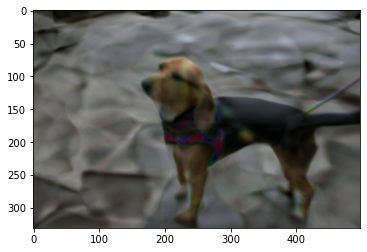

In [193]:
plt.imshow(collect_rgb)

In [158]:
checkpoint["loss"]

555.4655866214738

In [159]:
checkpoint["source_image_size"]

(331, 497)

In [160]:
x_range = np.linspace(0, 1, n_x)
y_range = np.linspace(0, 1, n_y)

In [161]:
x_range[150:270].min(), x_range[150:270].max()

(0.3024193548387097, 0.5423387096774194)

In [162]:
y_range[50:120].min(), y_range[50:120].max()

(0.15151515151515152, 0.3606060606060606)

In [196]:
# n_y, n_x = checkpoint["source_image_size"]
test_shape = (100, 200)
recon_input = CoordinateArrayDataset(test_shape[1], test_shape[0], (-0.1, 1.1), (-0.1, 1.1))
recon_input_loader = DataLoader(recon_input, batch_size=256, shuffle=False, drop_last=False)

collect_arr = []

for batch in recon_input_loader:
    with torch.no_grad():
        collect_arr.append(model(batch["features"]).detach().numpy())
        
collect = np.concatenate(collect_arr, axis=0)
collect_rgb = rectify_pixel_values(collect, mode=checkpoint["output_mode"], target_shape=test_shape)

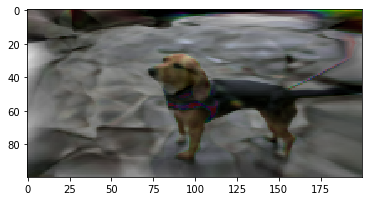

In [197]:
plt.imshow(collect_rgb, interpolation="none")

In [ ]:
# make reconstruct function with optional buffer of extra pixels (to be hallucinated)

In [198]:
img_path

'/shed/photo/export/watkins_glen_camping_aug2020/instagram/0003_DSC07470.png'

In [201]:
from pathlib import Path

q = Path(img_path)
isinstance(q, Path)

True

In [202]:
checkpoint.keys()

dict_keys(['output_mode', 'source_image_path', 'source_image_size', 'feature_encoding_config', 'model_args', 'model_state', 'opt_state', 'loss'])

In [203]:
checkpoint["source_image_size"]

(331, 497)

In [1]:
from reconstruct import reconstruct_single
import matplotlib.pyplot as plt

In [2]:
import torch

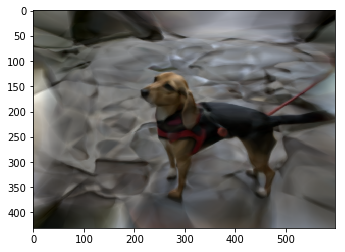

In [95]:
checkpoint_path = "/shed/data/mlp_image_reconstruction_checkpoints/mabel_ithaca_experiment_256x5/checkpoint_00144.pt"
# checkpoint_path = "/shed/data/mlp_image_reconstruction_checkpoints/mabel_ithaca_experiment_final512/checkpoint_00144.pt"
# checkpoint_path = "/shed/data/mlp_image_reconstruction_checkpoints/mabel_ithaca_experiment_tungsten/mode_RGB/checkpoint_00199.pt"
img = reconstruct_single(checkpoint_path, hallucination_buffer=50, scale_factor=1)
plt.imshow(img)

In [17]:
# check contributions from each unit

In [28]:
checkpoint = torch.load(checkpoint_path)
model = MLP(**checkpoint["model_args"])
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [41]:
from dataset import CoordinateArrayDataset
import numpy as np

In [37]:
feature_extractor = model.net[:10]

In [38]:
n_y, n_x = checkpoint["source_image_size"]
dataset = CoordinateArrayDataset(n_x, n_y)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=False)

feature_arrs = []

for batch in dataloader:
    with torch.no_grad():
        feature_arrs.append(feature_extractor(batch["features"]).detach().numpy())

In [42]:
features = np.concatenate(feature_arrs, axis=0)
features.shape

(164838, 256)

In [62]:
model.net[-1].weight[0, :]

tensor([-8.5036e-02, -3.7457e-01,  1.5627e-01,  1.6671e-02,  1.3769e-02,
        -1.3445e+00, -8.0944e-03, -2.2717e-02,  8.2863e-02,  1.8926e-01,
         9.5188e-03,  7.4841e-02, -2.5120e-02, -2.1003e-02,  6.5994e-03,
         1.8022e-01,  9.7614e-03,  1.6723e-01,  1.0317e-02,  2.3394e-02,
         5.8939e-02,  4.3708e-03, -1.9076e-02,  2.1201e-02, -1.2391e-03,
         9.4944e-02, -1.1474e+00, -2.6313e-02, -2.0254e-02, -3.6536e-02,
         1.7545e-02,  6.8940e-02,  5.7732e-02,  7.9604e-02, -1.3106e-02,
         5.5644e-02,  1.5260e-01, -6.5974e-02,  1.6240e-02,  1.8567e-01,
        -1.0213e-02, -2.1675e-02, -1.6618e-02, -3.4321e-02,  1.0621e-01,
         8.5900e-02,  7.7884e-02,  6.1633e-03,  1.1956e-01,  1.1429e-01,
         3.3582e-02,  7.9666e-02, -5.4343e-02, -4.2534e-02,  1.8489e-01,
         1.0517e-01, -1.8833e-03, -6.7342e-01, -8.6842e-03, -2.0683e-02,
         4.3322e-02,  1.5161e-01, -1.0218e+00, -1.3108e-02,  1.8997e-03,
         1.0153e-01,  5.4196e-02, -8.0268e-01,  1.8

In [73]:
(torch.tensor(features[100, :]) * model.net[-1].weight[2, :]).sum()

tensor(43.3509, grad_fn=<SumBackward0>)

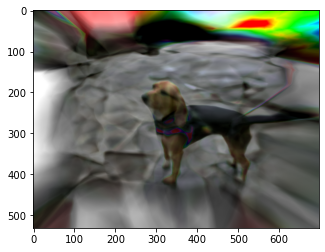

In [232]:
plt.imshow(img)

In [222]:
checkpoint["source_image_size"]

(331, 497)

In [230]:
331 * 497 * 4

658028

In [228]:
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [229]:
(2 * 256) + (3 * 256 * 256) + (3 * 256)

197888

In [236]:
cv2.imwrite("./test.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

In [237]:
img

array([[[ 29,  33,  27],
        [ 30,  34,  27],
        [ 30,  35,  28],
        ...,
        [  0, 255,   9],
        [  0, 255,   9],
        [  0, 255,  17]],

       [[ 30,  34,  28],
        [ 31,  35,  28],
        [ 32,  36,  29],
        ...,
        [  0, 255,   0],
        [  0, 255,   9],
        [  0, 255,   9]],

       [[ 31,  35,  28],
        [ 32,  36,  29],
        [ 33,  37,  30],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   9]],

       ...,

       [[ 37,  30,  24],
        [ 37,  29,  24],
        [ 37,  29,  24],
        ...,
        [ 99,  99,  99],
        [100, 100, 100],
        [101, 101, 101]],

       [[ 37,  29,  24],
        [ 37,  29,  24],
        [ 38,  29,  25],
        ...,
        [ 97,  97,  97],
        [ 98,  98,  98],
        [ 99,  99,  99]],

       [[ 37,  29,  24],
        [ 38,  29,  25],
        [ 38,  29,  25],
        ...,
        [ 95,  95,  95],
        [ 96,  96,  96],
        [ 97,  97,  97]]